In [1]:
from sklearn import linear_model
from scipy.stats import t,laplace,norm,multivariate_normal
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from sklearn import model_selection
from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression,Ridge,Lasso

from sklearn.preprocessing import scale
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

%matplotlib inline

### Ordinary Linear Regression
We use np.polyfit with order = 1 to fit a line to the 1-D data.

In [2]:
#A helper method for pretty-printing linear models
def pretty_print_linear(coefs, intercept, names = None, sort = False):
    if names == None:
        names = ["X%s" % x for x in range(1,1+len(coefs))]
    lst = zip(coefs, names)
    if sort:
        lst = sorted(lst,  key = lambda x:-np.abs(x[0]))
    return "%6.3f"%intercept+" + " +" + ".join("%6.3f * %s" % (coef, name)
                                   for coef, name in lst)

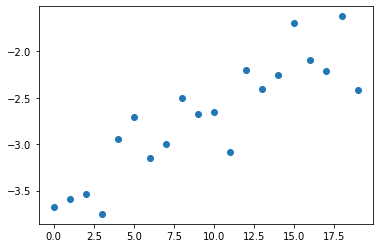

In [3]:
#generate some data
x = np.arange(20)
w = np.array([-3.8,0.11])
y = w[0] + w[1]*x
sigma2 = 0.1
y = y + np.random.normal(0,sqrt(sigma2),x.shape[0])
plt.scatter(x,y)

In [4]:
# fit model - note that LinearRegression's fit function adds the intercept by default
x = np.transpose(np.reshape(x,[1,len(x)]))
y = np.transpose(np.reshape(y,[1,len(y)]))
lr = LinearRegression()
lr.fit(x,y)
print(pretty_print_linear(lr.coef_,lr.intercept_))

-3.737 +  0.101 * X1


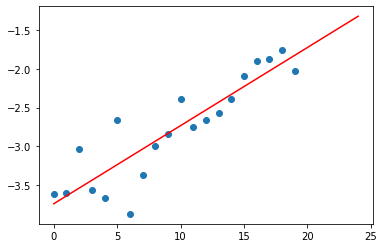

In [5]:
xtest = np.transpose(np.reshape(range(25),[1,len(range(25))]))
ytest = lr.predict(xtest)
plt.scatter(x,y)
plt.plot(xtest,ytest, color="red")

### Impact of outliers
OLE is susceptible to outliers because of the square term in the loss function. For Bayesian regression, the issue arises because of the square term in the pdf of the Gaussian distribution. See below for alternate distributions.

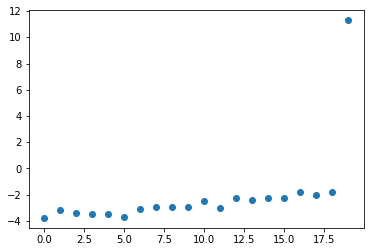

In [6]:
# adding outliers
y[19] = -3*y[0]
plt.scatter(x,y)

In [7]:
# fit model - note that LinearRegression's fit function adds the intercept by default
x = np.transpose(np.reshape(x,[1,len(x)]))
y = np.transpose(np.reshape(y,[1,len(y)]))
lr = LinearRegression()
lr.fit(x,y)
print(pretty_print_linear(lr.coef_,lr.intercept_))


-4.855 +  0.291 * X1


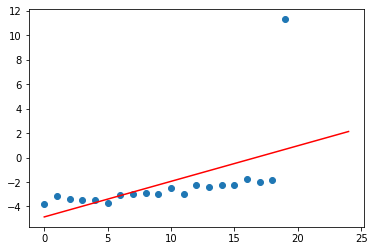

In [8]:
xtest = np.transpose(np.reshape(range(25),[1,len(range(25))]))
ytest = lr.predict(xtest)
plt.scatter(x,y)
plt.plot(xtest, ytest, color="red")

### Using robust regression
The statsmodels package has a robust linear regression model function (rlm) 

In [9]:
import statsmodels.api as sm
x1 = np.transpose(np.vstack([np.ones(x.shape[0]),x.flatten()]))
# Fit model and print summary
rlm_model = sm.RLM(y, x1, M=sm.robust.norms.HuberT())
w = rlm_model.fit()
w =  w.params
print(pretty_print_linear(w[1:],w[0]))


-3.782 +  0.112 * X1


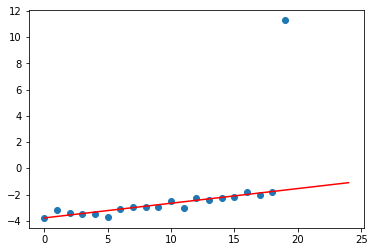

In [10]:
xtest = np.transpose(np.reshape(range(25),[1,len(range(25))]))
ytest = w[0] + w[1]*xtest
plt.scatter(x,y)
plt.plot(xtest, ytest, color="red")

### Handling outliers using other distributions
Below are some alternate distributions with less fat tail than Gaussian.

#### Laplace distribution
The distribution is defined using two parameters: $\mu$ and $b$. You can compute the <i>density</i> using the <b>probability density function</b>:
$$p(x) = \frac{1}{2b}\exp\left(-\frac{\vert x - \mu\vert}{b}\right)$$

#### Student-t distribution
The distribution is defined using one parameter: $\nu$ or degrees of freedom. You can compute the <i>density</i> using the <b>probability density function</b>:
$$p(x) = \frac{\Gamma\left(\frac{\nu + 1}{2}\right)}{\sqrt{\nu\pi}{\Gamma\left(\frac{\nu}{2}\right)}}\left(1 + \frac{x^2}{\nu}\right)^{-\frac{\nu+1}{2}}$$


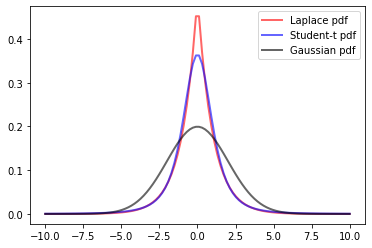

In [11]:
# comparing student-t, norm, laplace
s = np.linspace(-10,10, 100)
df = 2.74335149908
plt.plot(s, laplace.pdf(s),'r-', lw=2, alpha=0.6, label='Laplace pdf')#assuming b = 1 and \mu = 0
plt.plot(s, t.pdf(s,df),'b-', lw=2, alpha=0.6, label='Student-t pdf')#nu = df
plt.plot(s, norm.pdf(s,0,2),'k-', lw=2, alpha=0.6, label='Gaussian pdf')
plt.legend()

### Demonstrating Overfitting with Linear Regression
Also how to control the overfitting using Ridge Regression

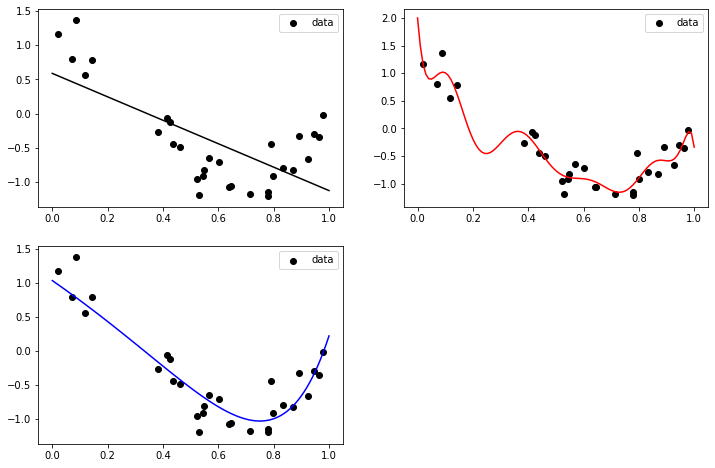

In [12]:
rng = np.random.RandomState(0)
# Generate sample data
np.random.seed(0)
n_samples = 30
true_fun = lambda X: np.cos(1.5 * np.pi * X)
X = np.sort(np.random.rand(n_samples))
y = true_fun(X) + np.random.randn(n_samples) * 0.2
X = X[:,np.newaxis]
# Learn linear regression model
lrmodel = LinearRegression()
lrmodel.fit(X,y)
# Do polynomial basis expansion
polynomial_features = PolynomialFeatures(degree=12,include_bias=False)
# fit linear model on expanded features
lrmodel1 = LinearRegression()
pipeline = Pipeline([("polynomial_features", polynomial_features),
                     ("linear_regression", lrmodel1)])
pipeline.fit(X,y)
# fit ridge regression model on expanded features
rrmodel = Ridge(alpha=0.1)
pipeline1 = Pipeline([("polynomial_features", polynomial_features),
                     ("ridge_regression", rrmodel)])
pipeline1.fit(X,y)

# plot the fitted lines
X_all = np.linspace(0, 1, 100)
fig = plt.figure(figsize=[12,8])
plt.subplot(2,2,1)
plt.plot(X_all, lrmodel.predict(X_all[:, np.newaxis]),color='k',label='')
plt.scatter(X,y, c='k', label='data')
plt.legend()
plt.subplot(2,2,2)
plt.plot(X_all, pipeline.predict(X_all[:, np.newaxis]),color='r')
plt.scatter(X,y, c='k', label='data')
plt.legend()
plt.subplot(2,2,3)
plt.plot(X_all, pipeline1.predict(X_all[:, np.newaxis]),color='b')
plt.scatter(X,y, c='k', label='data')
plt.legend()

### Using Ridge Regression to Control Impact of correlated variables

In [13]:
np.random.seed(0)
size = 5000
 
#A dataset with 3 features
X = np.random.normal(0, 1, (size, 3))
#Y = X0 + 2*X1 + noise
Y = X[:,0] + 2*X[:,1] + np.random.normal(0, 2, size)
lr = LinearRegression()
lr.fit(X, Y)
print(pretty_print_linear(lr.coef_,lr.intercept_))

 0.033 +  0.984 * X1 +  1.995 * X2 + -0.041 * X3


In [14]:
# adding correlated variables
size = 100
X_seed = np.random.normal(0, 1, size)
for i in range(10):
    np.random.seed(seed=i)
    X1 = X_seed + np.random.normal(0, .1, size)
    X2 = X_seed + np.random.normal(0, .1, size)
    X3 = X_seed + np.random.normal(0, .1, size)
    Y = X1 + X2 + X3 + np.random.normal(0, 1, size)
    X = np.array([X1, X2, X3]).T
 
    lr = LinearRegression()
    lr.fit(X,Y)
    print("Linear model:", pretty_print_linear(lr.coef_,lr.intercept_))
 

Linear model: -0.172 + -0.114 * X1 +  1.210 * X2 +  1.763 * X3
Linear model: -0.025 +  0.845 * X1 +  1.127 * X2 +  1.057 * X3
Linear model:  0.244 + -0.199 * X1 +  1.181 * X2 +  2.023 * X3
Linear model: -0.139 +  1.363 * X1 +  1.599 * X2 +  0.003 * X3
Linear model:  0.098 +  1.013 * X1 +  1.535 * X2 +  0.406 * X3
Linear model:  0.144 +  0.717 * X1 +  0.764 * X2 +  1.584 * X3
Linear model:  0.025 +  1.330 * X1 +  1.767 * X2 + -0.149 * X3
Linear model: -0.120 +  1.854 * X1 +  1.535 * X2 + -0.539 * X3
Linear model:  0.045 + -0.682 * X1 +  0.786 * X2 +  2.921 * X3
Linear model:  0.036 +  1.836 * X1 + -0.855 * X2 +  1.795 * X3


In [15]:
# handling correlated variables through Ridge Regression
size = 100
X_seed = np.random.normal(0, 1, size)
for i in range(10):
    np.random.seed(seed=i)
    X1 = X_seed + np.random.normal(0, .1, size)
    X2 = X_seed + np.random.normal(0, .1, size)
    X3 = X_seed + np.random.normal(0, .1, size)
    Y = X1 + X2 + np.random.normal(0, 1, size)
    X = np.array([X1, X2, X3]).T
 
    ridge = Ridge(alpha=10)
    ridge.fit(X,Y)
    print("Ridge model:", pretty_print_linear(ridge.coef_,ridge.intercept_))


Ridge model: -0.180 +  0.555 * X1 +  0.667 * X2 +  0.599 * X3
Ridge model: -0.008 +  0.636 * X1 +  0.656 * X2 +  0.582 * X3
Ridge model:  0.260 +  0.540 * X1 +  0.641 * X2 +  0.635 * X3
Ridge model: -0.194 +  0.719 * X1 +  0.728 * X2 +  0.506 * X3
Ridge model:  0.079 +  0.678 * X1 +  0.738 * X2 +  0.501 * X3
Ridge model:  0.154 +  0.662 * X1 +  0.657 * X2 +  0.649 * X3
Ridge model: -0.012 +  0.752 * X1 +  0.757 * X2 +  0.514 * X3
Ridge model: -0.130 +  0.743 * X1 +  0.643 * X2 +  0.408 * X3
Ridge model:  0.032 +  0.521 * X1 +  0.691 * X2 +  0.784 * X3
Ridge model:  0.004 +  0.804 * X1 +  0.525 * X2 +  0.646 * X3


### Using LASSO to control overfitting

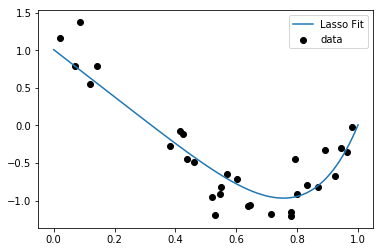

In [23]:
# fit LASSO on expanded features
llmodel = Lasso(alpha=0.01)
pipeline2 = Pipeline([("polynomial_features", polynomial_features),
                     ("lasso_regression", llmodel)])
pipeline2.fit(X,y)
# plot the fitted lines
X_all = np.linspace(0, 1, 100)
plt.plot(X_all, pipeline2.predict(X_all[:, np.newaxis]),label='Lasso Fit')
plt.scatter(X,y, c='k', label='data')
plt.legend()

### Demonstrating the role of Lasso in inducing sparsity
We will use the Boston housing data set to study this phenomenon

In [16]:
boston = load_boston()
scaler = StandardScaler()
X = scaler.fit_transform(boston["data"])
Y = boston["target"]
names = boston["feature_names"]

In [18]:
# fit linear regression
lrmodel = Ridge(alpha=0.1)
lrmodel.fit(X, Y)
scores = -np.mean(model_selection.cross_val_score(lrmodel,
    X, Y, scoring="neg_mean_squared_error", cv=10))
print("Cross validation error: %.4f"%scores)
print("Linear regression model: ", pretty_print_linear(lrmodel.coef_, lrmodel.intercept_, sort = True))
#print("Linear regression model: ", pretty_print_linear(lrmodel.coef_, lrmodel.intercept_, names, sort = True))

Cross validation error: 34.7475
Linear regression model:  22.533 + -3.747 * X13 + -3.102 * X8 +  2.672 * X6 +  2.652 * X9 + -2.069 * X10 + -2.061 * X11 + -2.057 * X5 +  1.079 * X2 + -0.920 * X1 +  0.857 * X12 +  0.683 * X4 +  0.141 * X3 +  0.020 * X7


In [19]:
# fit Lasso
lasso = Lasso(alpha=0.3)
lasso.fit(X, Y)
scores = -np.mean(model_selection.cross_val_score(lasso,
    X, Y, scoring="neg_mean_squared_error", cv=10))
print("Cross validation error: %.4f"%scores)
print("Lasso model: ", pretty_print_linear(lasso.coef_, lasso.intercept_, sort = True))

Cross validation error: 34.6789
Lasso model:  22.533 + -3.707 * X13 +  2.992 * X6 + -1.757 * X11 + -1.081 * X8 + -0.700 * X5 +  0.631 * X12 +  0.540 * X4 + -0.236 * X1 +  0.081 * X2 + -0.000 * X3 + -0.000 * X7 +  0.000 * X9 + -0.000 * X10


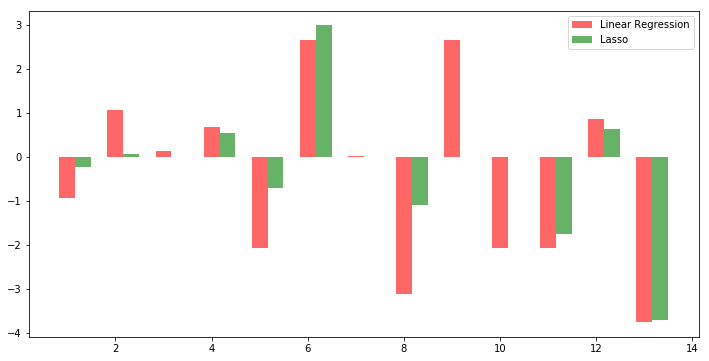

In [20]:
# comparing the two for sparsity
fig = plt.figure(figsize=[12,6])
plt.bar(range(1,len(lrmodel.coef_)+1),lrmodel.coef_,color='red',width=0.33,alpha=0.6)
plt.bar(np.arange(1.33,len(lrmodel.coef_)+1),lasso.coef_,color='green',width=0.33,alpha=0.6)
plt.legend(['Linear Regression', 'Lasso'])

(-5, 5)

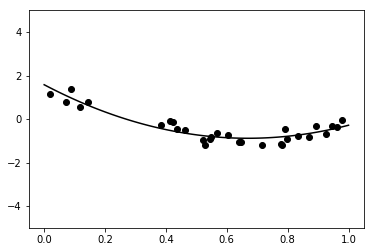

In [30]:
rng = np.random.RandomState(0)
# Generate sample data
np.random.seed(0)
n_samples = 30
true_fun = lambda X: np.cos(1.5 * np.pi * X)
X = np.sort(np.random.rand(n_samples))
y = true_fun(X) + np.random.randn(n_samples) * 0.2
X = X[:,np.newaxis]
# Learn linear regression model
lrmodel = LinearRegression()
lrmodel.fit(X,y)
# Do polynomial basis expansion
polynomial_features = PolynomialFeatures(degree=2,include_bias=False)
# fit linear model on expanded features
lrmodel1 = LinearRegression()
pipeline = Pipeline([("polynomial_features", polynomial_features),
                     ("linear_regression", lrmodel1)])
pipeline.fit(X,y)
X_all = np.linspace(0, 1, 100)
plt.plot(X_all, pipeline.predict(X_all[:, np.newaxis]),color='k',label='')
plt.scatter(X,y, c='k', label='data')
plt.ylim([-5,5])